<a href="https://colab.research.google.com/github/azh248/galaxy-mergers/blob/main/zoobot_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import logging
import os
import sys

import numpy as np
import pandas as pd

logging.basicConfig(level=logging.INFO)

In [2]:
import torch
torch.__version__

'2.5.1+cu121'

## Install Zoobot

In [3]:
!pip install zoobot[pytorch-colab] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 47.2 MB/s eta 0:00:00


In [4]:
# colab is weird sometimes and erratically needs this hack to make imports work
# no need to do this locally
sys.path.append('/content/galaxy-datasets')
sys.path.append('/content/zoobot')
sys.path.append('/content/zoobot/pytorch')


## Download Catalogs of Images and Labels

Each catalog should be a dataframe with columns of "id_str", "file_loc", and any labels.

Here I'm using galaxy-datasets to download some premade data - check it out for examples.

In [5]:


# galaxy-datasets is a dependency of Zoobot.
# It has code handling downloading and loading data.
from galaxy_datasets import gz_candels

data_dir = '/content/gz_candels'

train_catalog_raw, _ = gz_candels(root=data_dir, download=True, train=True)
test_catalog_raw, _ = gz_candels(root=data_dir, download=True, train=False)
train_catalog = pd.DataFrame()
test_catalog = pd.DataFrame()

100%|██████████| 4177120/4177120 [00:00<00:00, 78465942.88it/s]


100%|██████████| 1162980/1162980 [00:00<00:00, 51971527.60it/s]


100%|██████████| 6446950787/6446950787 [07:06<00:00, 15107614.84it/s]


Extracting /content/gz_candels/candels_images.tar.gz to /content/gz_candels


In [6]:
# # FOR DEBUGGING PURPOSES ONLY

# train_catalog = pd.DataFrame()
# test_catalog = pd.DataFrame()

# print(len(train_catalog_raw))
# print(len(test_catalog_raw))

# print(len(train_catalog_raw.index))
# print(len(test_catalog_raw.index))

In [7]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 39.0 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [8]:
# calculate fraction of respondents who voted that the picture was of a merger
total_mergers = train_catalog_raw['merging-candels_merger'] + train_catalog_raw['merging-candels_both']
total_responses = total_mergers + train_catalog_raw['merging-candels_neither'] + train_catalog_raw['merging-candels_tidal-debris']
train_catalog_raw['merger_frac'] = total_mergers / total_responses
total_mergers = test_catalog_raw['merging-candels_merger'] + test_catalog_raw['merging-candels_both']
total_responses = total_mergers + test_catalog_raw['merging-candels_neither'] + test_catalog_raw['merging-candels_tidal-debris']
test_catalog_raw['merger_frac'] = total_mergers / total_responses

label_cols = ['merger']  # will use later

# convert fraction of merger votes to a binary yes/no classification
mergeCol = train_catalog_raw['merger_frac']
train_catalog_raw = train_catalog_raw.loc[(mergeCol > 0.8) | (mergeCol < 0.2)]
train_catalog_raw['merger'] = train_catalog_raw['merger_frac'] > 0.8
train_catalog_raw.head()

mergeCol = test_catalog_raw['merger_frac']
test_catalog_raw = test_catalog_raw.loc[(mergeCol > 0.8) | (mergeCol < 0.2)]
test_catalog_raw['merger'] = test_catalog_raw['merger_frac'] > 0.8
test_catalog_raw.head()

# balance dataset
train_mergers = train_catalog_raw.loc[train_catalog_raw['merger'] == 1]
train_non_mergers = train_catalog_raw.loc[train_catalog_raw['merger'] == 0]
train_balanced_non_mergers = train_non_mergers.head(len(train_mergers))
train_catalog = pd.concat([train_mergers, train_balanced_non_mergers])

test_mergers = test_catalog_raw.loc[test_catalog_raw['merger'] == 1]
test_non_mergers = test_catalog_raw.loc[test_catalog_raw['merger'] == 0]
test_balanced_non_mergers = test_non_mergers.head(len(test_mergers))
test_catalog = pd.concat([test_mergers, test_balanced_non_mergers])

# reset indexes of dataframe (otherwise they will retain original indexes from before slicing)
train_catalog.reset_index(drop=True,inplace=True)
test_catalog.reset_index(drop=True,inplace=True)

<ipython-input-8-f8f2985e3a68>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_catalog_raw['merger'] = train_catalog_raw['merger_frac'] > 0.8
<ipython-input-8-f8f2985e3a68>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_catalog_raw['merger'] = test_catalog_raw['merger_frac'] > 0.8


In [9]:
# train_catalog['file_loc'] = train_catalog_raw['file_loc']
# test_catalog['file_loc'] = test_catalog_raw['file_loc']
train_catalog['id_str'] = train_catalog['filename']
test_catalog['id_str'] = test_catalog['filename']
# train_catalog['filename'] = train_catalog_raw['filename']
# test_catalog['filename'] = test_catalog_raw['filename']

train_catalog.head()
test_catalog.head()

# print(len(train_catalog_raw.index))
# print(len(train_catalog_raw.columns))
# print(len(train_catalog.index))
# print(len(train_catalog.columns))

,smooth-or-featured-candels_smooth,smooth-or-featured-candels_features,smooth-or-featured-candels_artifact,how-rounded-candels_completely,how-rounded-candels_in-between,how-rounded-candels_cigar-shaped,clumpy-appearance-candels_yes,clumpy-appearance-candels_no,clump-count-candels_1,clump-count-candels_2,...,merging-candels_tidal-debris,merging-candels_both,merging-candels_neither,filename,ra,dec,file_loc,merger_frac,merger,id_str
0,27.0,25.0,22.0,18.0,9.0,0.0,22.0,3.0,0.0,22.0,...,0.0,2.0,7.0,GDS_2428.jpg,53.116118,-27.893268,/content/gz_candels/images/GDS_2428.jpg,0.865385,True,GDS_2428.jpg
1,35.0,21.0,19.0,0.0,16.0,19.0,7.0,14.0,0.0,7.0,...,0.0,7.0,9.0,COS_27140.jpg,150.175380,2.524987,/content/gz_candels/images/COS_27140.jpg,0.839286,True,COS_27140.jpg
2,38.0,21.0,17.0,19.0,18.0,1.0,16.0,5.0,0.0,11.0,...,1.0,5.0,7.0,GDS_14580.jpg,53.126990,-27.779735,/content/gz_candels/images/GDS_14580.jpg,0.864407,True,GDS_14580.jpg
3,39.0,9.0,24.0,3.0,34.0,2.0,5.0,4.0,2.0,3.0,...,1.0,3.0,8.0,GDS_6668.jpg,53.126628,-27.848169,/content/gz_candels/images/GDS_6668.jpg,0.812500,True,GDS_6668.jpg
4,9.0,8.0,6.0,3.0,6.0,0.0,6.0,2.0,0.0,3.0,...,0.0,8.0,3.0,GDS_21383.jpg,53.124456,-27.719193,/content/gz_candels/images/GDS_21383.jpg,0.823529,True,GDS_21383.jpg


In [10]:
import albumentations as A
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomBrightnessContrast(p=1,brightness_limit=(0,0.4),
                               contrast_limit=(0,1)),
    A.VerticalFlip(p=1),
    A.AdvancedBlur(blur_limit=11,p=1),
    A.Sharpen(p=1),
    A.PlasmaShadow(p=1),
    A.PlanckianJitter(p=1),
    A.FancyPCA(p=1),
    A.Illumination(p=1),
    A.Emboss(p=1),
    A.MotionBlur(p=1),
    A.ColorJitter(brightness=(0.4,0.6),hue=0,p=1),
    A.RGBShift(r_shift_limit=(0, 20), g_shift_limit=(0, 20),
               b_shift_limit=(0, 20)),
    A.ToGray(p=1),
    A.InvertImg(p=1)
])

newpath = '/content/gz_candels/images_transformed'
if not os.path.exists(newpath):
  os.mkdir(newpath)

for n in range(len(train_catalog.index)):
  file_loc = train_catalog.iloc[n]['file_loc']
  new_file_loc = '/content/gz_candels/images_transformed/' + train_catalog.iloc[n]['filename']
  if not os.path.exists(new_file_loc):
    im = Image.open(file_loc)
    transformed_im_dict = transform(image=np.array(im))
    transformed_im = Image.fromarray(transformed_im_dict['image'])
    # print(type(transformed_im))
    # plt.imshow(im)
    # plt.show()
    # plt.imshow(transformed_im)
    # plt.show()
    transformed_im.save(new_file_loc)
  train_catalog.at[n,'file_loc'] = new_file_loc

for n in range(len(test_catalog.index)):
  file_loc = test_catalog.iloc[n]['file_loc']
  new_file_loc = '/content/gz_candels/images_transformed/' + test_catalog.iloc[n]['filename']
  if not os.path.exists(new_file_loc):
    im = Image.open(file_loc)
    transformed_im_dict = transform(image=np.array(im))
    transformed_im = Image.fromarray(transformed_im_dict['image'])
    # print(type(transformed_im))
    # plt.imshow(im)
    # plt.show()
    # plt.imshow(transformed_im)
    # plt.show()
    # break
    transformed_im.save(new_file_loc)
  test_catalog.at[n,'file_loc'] = new_file_loc

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `UniformParams` with value `UniformParams(noise_type=...0, 0.0784313725490196)])` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [11]:
# example_multiclass_labels = pd.DataFrame([[0,1,0],[1,0,0],[0, 0,1]], columns=['class_a', 'class_b', 'class_c'])
# example_multiclass_labels # just to illustrate. not used here as we're doing binary classification.

In [12]:
all_id_strs = list(train_catalog['filename']) + list(test_catalog['filename'])
assert pd.value_counts(all_id_strs).max() == 1

<ipython-input-12-84ebfc147caf>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  assert pd.value_counts(all_id_strs).max() == 1
<ipython-input-12-84ebfc147caf>:2: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  assert pd.value_counts(all_id_strs).max() == 1


In [13]:
assert all([os.path.isfile(loc) for loc in train_catalog['file_loc']])

In [14]:
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule

datamodule = GalaxyDataModule(
  label_cols=label_cols,  # specifying which columns to load as labels with `label_cols`
  catalog=train_catalog,
  batch_size=32,
  resize_after_crop=224,  # the size of the images input to the model
  num_workers=2,  # sets the parallelism for loading data. 2 works well on colab.
  greyscale=False  # Most Zoobot checkpoints expect color images
)

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


In [15]:
# just to demonstrate what datamodule returns. you don't need to do this.
datamodule.setup()
for batch in datamodule.train_dataloader():
  images = batch[0]
  labels = batch[1]
  print(images.min(), images.max(), images.shape)
  print(labels)
  break

tensor(0.) tensor(1.) torch.Size([32, 3, 224, 224])
tensor([0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
        1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.])


## Download Pretrained Model

In [16]:
from zoobot.pytorch.training.finetune import FinetuneableZoobotClassifier

model = FinetuneableZoobotClassifier(

    # arguments for any FinetuneableZoobot class
    # there are many options for customizing finetuning. See the FinetuneableZoobotAbstract docstring.
    name='hf_hub:mwalmsley/zoobot-encoder-convnext_pico',
    n_blocks=5,  # Finetune this many blocks. Set 0 for only the head. Set e.g. 1, 2 to finetune deeper (5 max for convnext).
    learning_rate=1e-5,  # use a low learning rate
    lr_decay=0.5,  # reduce the learning rate from lr to lr^0.5 for each block deeper in the network

    # arguments specific to FinetuneableZoobotClassifier
    num_classes=2
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

# Now the Actual Finetuning

In [17]:
from zoobot.pytorch.training.finetune import get_trainer

# TODO you can update these paths to suit own data
save_dir = os.path.join('/content/zoobot/results/pytorch/finetune/finetune_binary_classification')

trainer = get_trainer(save_dir, accelerator='auto', devices='auto', max_epochs=20)
trainer.fit(model, datamodule)


# should reach about 85% accuracy, loss of about 0.40

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type           | Params | Mode 
-------------------------------------------------------------
0 | encoder           | ConvNeXt       | 8.5 M  | train
1 | train_loss_metric | MeanMetric     | 0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 19: 'finetuning/val_loss' reached 0.68861 (best 0.68861), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/0.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 38: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 57: 'finetuning/val_loss' reached 0.67690 (best 0.67690), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 76: 'finetuning/val_loss' reached 0.65533 (best 0.65533), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 95: 'finetuning/val_loss' reached 0.61150 (best 0.61150), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 114: 'finetuning/val_loss' reached 0.60160 (best 0.60160), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 133: 'finetuning/val_loss' reached 0.54396 (best 0.54396), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/6.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 152: 'finetuning/val_loss' reached 0.50020 (best 0.50020), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/7.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 171: 'finetuning/val_loss' reached 0.42829 (best 0.42829), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/8.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 190: 'finetuning/val_loss' reached 0.39542 (best 0.39542), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 209: 'finetuning/val_loss' reached 0.27726 (best 0.27726), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/10.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 228: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 247: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 266: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 285: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 304: 'finetuning/val_loss' reached 0.27467 (best 0.27467), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/15.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 323: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 342: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 361: 'finetuning/val_loss' reached 0.23754 (best 0.23754), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/18.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 380: 'finetuning/val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [18]:
# now we can load the best checkpoint and make predictions
best_checkpoint = trainer.checkpoint_callback.best_model_path
finetuned_model = FinetuneableZoobotClassifier.load_from_checkpoint(best_checkpoint)

In [19]:
from zoobot.pytorch.predictions import predict_on_catalog

_ = predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  n_samples=1,
  # CAREFUL! For classification, we unpack a single column like [1, 0, 1, 2, ...] into N classes automatically
  # but when making predictions, we make a prediction per class, so (unlike for training) this prediction `label_cols` needs n_classes entries
  # e.g. [class_for_label_0, class_for_label_1, ...
  label_cols=['not_merger', 'merger'],  # name the output columns
  save_loc=os.path.join(save_dir, 'finetuned_predictions.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2, 'batch_size': 32, 'greyscale': False},
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Let's quickly check if they're any good:

In [20]:
predictions = pd.read_csv(os.path.join(save_dir, 'finetuned_predictions.csv'))
predictions.head()

,id_str,not_merger_pred,merger_pred
0,GDS_2428.jpg,0.891030,0.108970
1,COS_27140.jpg,0.005180,0.994820
2,GDS_14580.jpg,0.046786,0.953215
3,GDS_6668.jpg,0.001338,0.998662
4,GDS_21383.jpg,0.083225,0.916775


In [21]:
predictions = pd.merge(predictions, test_catalog[['id_str', 'file_loc', 'merger']])
predictions.head()

,id_str,not_merger_pred,merger_pred,file_loc,merger
0,GDS_2428.jpg,0.891030,0.108970,/content/gz_candels/images_transformed/GDS_242...,True
1,COS_27140.jpg,0.005180,0.994820,/content/gz_candels/images_transformed/COS_271...,True
2,GDS_14580.jpg,0.046786,0.953215,/content/gz_candels/images_transformed/GDS_145...,True
3,GDS_6668.jpg,0.001338,0.998662,/content/gz_candels/images_transformed/GDS_666...,True
4,GDS_21383.jpg,0.083225,0.916775,/content/gz_candels/images_transformed/GDS_213...,True


Accuracy: 0.908
0      0.108970
1      0.994820
2      0.953215
3      0.998662
4      0.916775
         ...   
245    0.105503
246    0.122126
247    0.024584
248    0.174180
249    0.197937
Name: merger_pred, Length: 250, dtype: float64


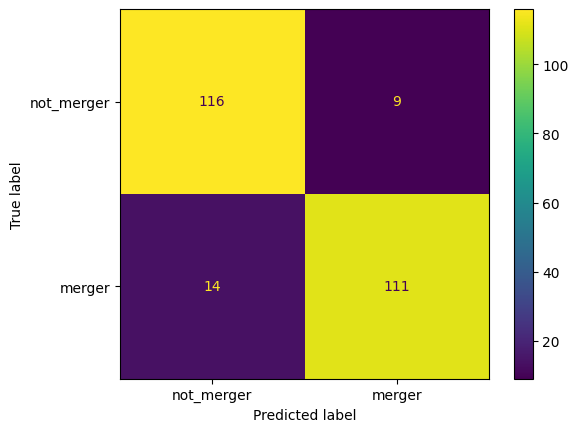

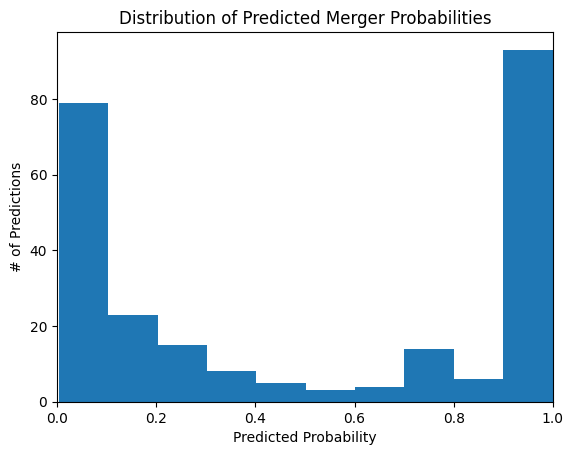

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

print('Accuracy:', np.mean(np.around(predictions['merger_pred']) == predictions['merger']))
print(predictions['merger_pred'])
cm = confusion_matrix(predictions['merger'],np.around(predictions['merger_pred']))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not_merger', 'merger'])
disp.plot()
plt.show()

# sns.kdeplot(predictions['merger_pred'])
# plt.xlim(0, 1)
# plt.show()

plt.hist(predictions['merger_pred'])
plt.xlim(0,1)
plt.ylabel("# of Predictions")
plt.xlabel("Predicted Probability")
plt.title("Distribution of Predicted Merger Probabilities")
plt.show()

In [23]:
def show_rings(df):
  # little utility function to visualise galaxies and our ring labels/predictions

  fig, axes = plt.subplots(ncols=5, figsize=(16, 3))
  for n in range(5):
    galaxy = df.iloc[n]

    im = Image.open(galaxy['file_loc'])
    axes[n].imshow(im)

    correct = np.around(galaxy['merger_pred']) == galaxy['merger']
    if correct:
      color = 'g'
    else:
      color = 'r'
    axes[n].text(20, 50, 'Pred: {:.2f}'.format(galaxy['merger_pred']), color=color)
    axes[n].text(20, 90, 'Label: {}'.format(galaxy['merger']), color=color)

    axes[n].axis('off')

104    COS_24698.jpg
18      GDS_5079.jpg
112    GDS_24274.jpg
36     UDS_26480.jpg
83     COS_18844.jpg
           ...      
129    GDS_21933.jpg
242     COS_1891.jpg
132     COS_3482.jpg
160    UDS_24028.jpg
180    COS_15889.jpg
Name: id_str, Length: 250, dtype: object


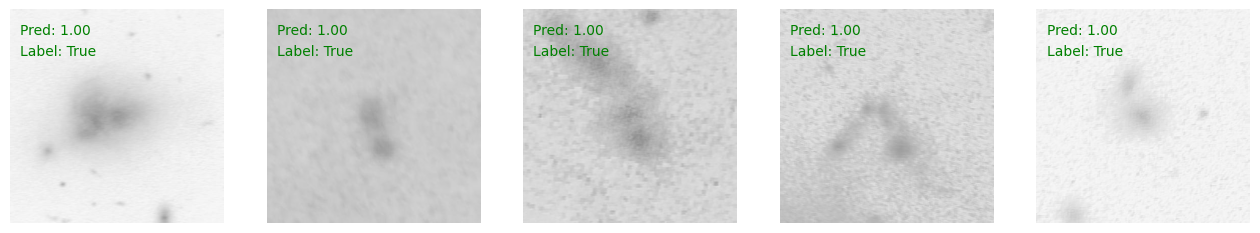

In [24]:
top_5_predictions = predictions.sort_values('merger_pred', ascending=False)
show_rings(top_5_predictions)
print(top_5_predictions['id_str'])

In [25]:
galrow = test_catalog.loc[test_catalog['filename'] == 'GDS_22130.jpg']
display(galrow)
print(galrow.to_string())
# print(test_catalog.loc[2422])
# plt.imshow(Image.open(galrow['file_loc']))

,smooth-or-featured-candels_smooth,smooth-or-featured-candels_features,smooth-or-featured-candels_artifact,how-rounded-candels_completely,how-rounded-candels_in-between,how-rounded-candels_cigar-shaped,clumpy-appearance-candels_yes,clumpy-appearance-candels_no,clump-count-candels_1,clump-count-candels_2,...,merging-candels_tidal-debris,merging-candels_both,merging-candels_neither,filename,ra,dec,file_loc,merger_frac,merger,id_str
55,34.0,24.0,17.0,14.0,20.0,0.0,21.0,3.0,0.0,8.0,...,1.0,7.0,10.0,GDS_22130.jpg,53.10871,-27.700054,/content/gz_candels/images_transformed/GDS_221...,0.810345,True,GDS_22130.jpg


    smooth-or-featured-candels_smooth  smooth-or-featured-candels_features  smooth-or-featured-candels_artifact  how-rounded-candels_completely  how-rounded-candels_in-between  how-rounded-candels_cigar-shaped  clumpy-appearance-candels_yes  clumpy-appearance-candels_no  clump-count-candels_1  clump-count-candels_2  clump-count-candels_3  clump-count-candels_4  clump-count-candels_5-plus  clump-count-candels_cant-tell  disk-edge-on-candels_yes  disk-edge-on-candels_no  edge-on-bulge-candels_yes  edge-on-bulge-candels_no  bar-candels_yes  bar-candels_no  has-spiral-arms-candels_yes  has-spiral-arms-candels_no  spiral-winding-candels_tight  spiral-winding-candels_medium  spiral-winding-candels_loose  spiral-arm-count-candels_1  spiral-arm-count-candels_2  spiral-arm-count-candels_3  spiral-arm-count-candels_4  spiral-arm-count-candels_5-plus  spiral-arm-count-candels_cant-tell  bulge-size-candels_none  bulge-size-candels_obvious  bulge-size-candels_dominant  merging-candels_merger  mergi

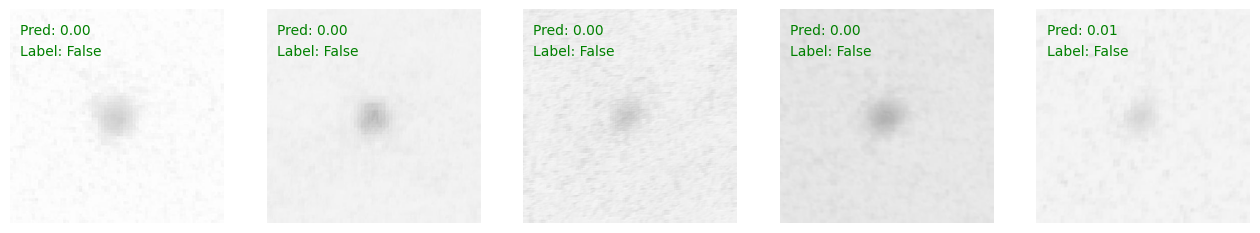

In [26]:
bottom_5_predictions = predictions.sort_values('merger_pred', ascending=True)
show_rings(bottom_5_predictions)

163     COS_1765.jpg
114     COS_9928.jpg
179     UDS_2057.jpg
17     GDS_22548.jpg
48     COS_20191.jpg
Name: id_str, dtype: object


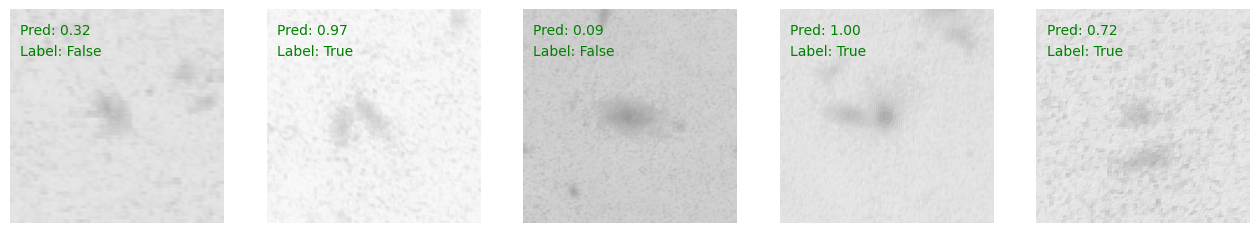

In [27]:
random_predictions = predictions.sample(5)
print(random_predictions['id_str'])
show_rings(random_predictions)

## Saving predictions to HDF5

By the way - you can also save predictions to hdf5. This is useful for saving higher-dimensional outputs (e.g. representations or multiple forward passes).

In [28]:
from zoobot.pytorch.predictions import predict_on_catalog

predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  n_samples=5,  # 5 forward passes with MC Dropout and different random augs
  label_cols=['not_ring', 'ring'],
  save_loc=os.path.join(save_dir, 'finetuned_predictions.hdf5'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2, 'batch_size': 32, 'greyscale': False},
)

import h5py

with h5py.File(os.path.join(save_dir, 'finetuned_predictions.hdf5')) as f:
  print(f.keys())
  print(f['predictions'].shape)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<KeysViewHDF5 ['id_str', 'label_cols', 'predictions']>
(250, 2, 5)
